## Kickstarter Projects
課題：クラウドファンディングが成功するかを**事前に**予測するモデルの構築を目指す。

Day1では、データをインポートして加工し、ロジスティック回帰をによるモデルを構築して評価した結果、予測の正答率は65.864%となった。Day2では説明変数の追加、モデルの検証、正則化およびSVMの導入により予測精度の向上を目指す。

Day1へのリンク：https://github.com/kobayashi-masashi/machine-learning/blob/master/Day1_work_小林優志.ipynb

In [1]:
# データのインポートおよび加工など（Day1と同様）
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_ks = pd.read_csv("./ks-projects-201801.csv")
# 使えないデータの削除
df_ks = df_ks.drop(columns=['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'])
df_ks = df_ks.query("state ==['failed', 'successful']")
# 二値化
df_ks["state"] = df_ks["state"] == "successful" # successful=>True, failed=>False
df_ks = df_ks.dropna()

# Day2

In [2]:
# データの確認
df_ks

,ID,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,False,GB,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,False,US,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,False,US,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,False,US,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26 13:38:27,True,US,50000.00
...,...,...,...,...,...,...,...,...,...,...
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,Food,USD,2017-04-19,2017-03-20 22:08:22,False,US,6500.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,2011-06-22 03:35:14,False,US,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,2010-07-01 19:40:30,False,US,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,2016-01-13 18:13:53,False,US,15000.00


## 1 モデルの検証方法
Day1ではホールドアウト法を用いて汎化性能を評価した。ここでは練習として、交差検証法を用いて汎化性能を算出する。

In [3]:
"""
全てDay1と同様の操作
"""
# 2100以上のデータがあるcountryのみ利用
# データ数が2100以上のカテゴリを抜き出す
df_country = pd.DataFrame() # 空のdataframe
for index, value in df_ks['country'].value_counts().iteritems():
    if value < 2100:
        df_tmp = df_ks[(df_ks["country"]==index)]
        df_tmp["country"] = "others"
        df_country = pd.concat([df_country, df_tmp])
        continue
    df_country = pd.concat([df_country, df_ks[(df_ks["country"]==index)]])
# データ数が2100以上のカテゴリを抜き出す
df_category = pd.DataFrame() # 空のdataframe
for index, value in df_ks['category'].value_counts().iteritems():
    if value < 2100:
        df_tmp = df_ks[(df_ks["category"]==index)]
        df_tmp["category"] = "others"
        df_category = pd.concat([df_category, df_tmp])
        continue
    df_category = pd.concat([df_category, df_ks[(df_ks["category"]==index)]])
# usd_goal_realのオーダーと成功/失敗のみのデータフレームを作成する。
df_ML = pd.DataFrame() # 煩雑になってきたので、使うものだけここに入れる。
df_ML["state"] = df_ks["state"]
# 地域
df_ML = pd.concat([df_ML, pd.get_dummies(df_country["country"], sparse=True)], axis=1)
# sparse: メモリの削減
df_ML = df_ML.drop(columns="others") # 全て0ならothers
# メインカテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_ks["main_category"], prefix="main_category", sparse=True)], axis=1)
df_ML = df_ML.drop(columns="main_category_Theater") # 全て0ならTheater
# カテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_category["category"], prefix="category", sparse=True)], axis=1)
df_ML = df_ML.drop(columns="category_others") # 全て0ならothers
df_ML["goal_band"] = pd.cut(df_ks["usd_goal_real"], [0, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e9], labels=range(1,8))
X = df_ML[df_ML.columns[1:]]
y = df_ML[df_ML.columns[0]]

D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 1.1 交差検証法（クロスバリデーション）
学習し、クロスバリデーションにより汎化性能を評価する。  
なお、数十万の学習データをそのまま用いて学習させるのはややナンセンスであるが、ロジスティック回帰は軽いモデルなためそのまま用いている。

In [4]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 交差検証法（クロスバリデーション）
from sklearn.model_selection import KFold # 交差検証法に関する関数

n_split = 5 # グループ数を設定（今回は5分割）
# 初期化
split_num = 1
accuracy_sum = 0.0
precision_sum = 0.0
recall_sum = 0.0
f1_score_sum = 0.0

for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx] #学習用データ
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]     #テスト用データ
    
    # 学習用データを使ってロジスティック回帰を学習
    clf = SGDClassifier(fit_intercept=True)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("Accuracy = %s"%round(accuracy*100, 3))
    print()
    
    accuracy_sum += accuracy #後で平均を取る
    precision_sum += precision[0]
    recall_sum += recall[0]
    f1_score_sum += f1_score[0]
    split_num += 1
# 最終的な値を出力    
print("Cross Validation accuracy  = %s"%round(accuracy_sum/n_split*100, 3))
print("Cross Validation recall    = %s"%round(recall_sum/n_split*100, 3))
print("Cross Validation precision = %s"%round(precision_sum/n_split*100, 3))
print("Cross Validation f1 score  = %s"%round(f1_score_sum/n_split*100, 3))

Fold 1
Accuracy = 64.927

Fold 2
Accuracy = 64.943

Fold 3
Accuracy = 65.166

Fold 4
Accuracy = 64.744

Fold 5
Accuracy = 65.03

Cross Validation accuracy  = 64.962
Cross Validation recall    = 81.992
Cross Validation precision = 66.79
Cross Validation f1 score  = 73.614
Wall time: 20 s


### 考察
以下の表にモデルの検証方法ごとの汎化性能の一覧を示す。今回の結果では、検証方法によらず汎化性能にはほとんど差が無かった。これは、十分なデータ数があったため、またホールドアウト法を用いる際には統計的な検討から説明変数とするカテゴリを決定したため（Day1レポート参照）であると考えられる。

|検証方法|accuracy|recall|precision|f1 score|
|:-|:-:|:-|:-|:-|
|ホールドアウト法|65.864%|78.002%|68.860%|73.146%|
|交差検証法(n=5)|64.962%|81.992%|66.790%|73.614%|

# 2 データの追加・加工

In [5]:
df_ML.columns

Index(['state', 'AU', 'CA', 'DE', 'FR', 'GB', 'IT', 'NL', 'US',
       'main_category_Art', 'main_category_Comics', 'main_category_Crafts',
       'main_category_Dance', 'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'category_Accessories', 'category_Animation', 'category_Apparel',
       'category_Apps', 'category_Art', 'category_Art Books',
       'category_Children's Books', 'category_Classical Music',
       'category_Comic Books', 'category_Comics', 'category_Country & Folk',
       'category_Crafts', 'category_Dance', 'category_Design',
       'category_Documentary', 'category_Drinks', 'category_Fashion',
       'category_Fiction', 'category_Film & Video', 'category_Food',
       'category_Gadgets', 'category_Games', 'category_Hardware'

### データの軽量化
カテゴリに関する変数が多く重たいので、成功または失敗しやすいいくつかのカテゴリを残して削除することとする。

In [6]:
# カテゴリ
c_keys = []
# 上位
key = df_ks.groupby("category").mean()["state"].sort_values().tail(5).keys()
c_keys = c_keys + list(key)
# 下位
key = df_ks.groupby("category").mean()["state"].sort_values().head(5).keys()
c_keys = c_keys + list(key)
c_keys = ["category_" + s for s in c_keys]
print(c_keys)

['category_Literary Spaces', 'category_Dance', 'category_Anthologies', 'category_Residencies', 'category_Chiptune', 'category_Apps', 'category_Web', 'category_Mobile Games', 'category_Video', 'category_Food Trucks']


In [7]:
# メインカテゴリ
mc_keys = []
# 上位
key = df_ks.groupby("main_category").mean()["state"].sort_values().tail(3).keys()
mc_keys = mc_keys + list(key)
# 下位
key = df_ks.groupby("main_category").mean()["state"].sort_values().head(3).keys()
mc_keys = mc_keys + list(key)
mc_keys = ["main_category_" + s for s in mc_keys]
print(mc_keys)

['main_category_Comics', 'main_category_Theater', 'main_category_Dance', 'main_category_Technology', 'main_category_Journalism', 'main_category_Crafts']


In [8]:
# カテゴリに関するものを削除
df_ML_wo_category = df_ML # バグ防止に仮置き
for column_name in df_ML:
    if 'category_' in column_name:
        df_ML_wo_category = df_ML_wo_category.drop(columns=column_name)
df_ML = df_ML_wo_category
# もう一度追加
# メインカテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_ks["main_category"], prefix="main_category", sparse=True)], axis=1)
# カテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_ks["category"], prefix="category", sparse=True)], axis=1)
df_ML.columns

Index(['state', 'AU', 'CA', 'DE', 'FR', 'GB', 'IT', 'NL', 'US', 'goal_band',
       ...
       'category_Wearables', 'category_Weaving', 'category_Web',
       'category_Webcomics', 'category_Webseries', 'category_Woodworking',
       'category_Workshops', 'category_World Music', 'category_Young Adult',
       'category_Zines'],
      dtype='object', length=184)

In [9]:
# ピックアップしたもののみ残す
keys = c_keys + mc_keys
df_ML_edit = df_ML # バグ防止に仮置き
for column_name in df_ML:
    if "category" in column_name:
        if column_name in keys:
            continue
        df_ML_edit = df_ML_edit.drop(columns=column_name)
df_ML = df_ML_edit

## 2.1 データの追加
Day1では利用しなかったdeadline, launchedおよびname列を利用することを考える。

### 期間(period)
deadlineおよびlaunchedの差から期間(period)を生成する。単位は日(days)として整理、計算する。

In [10]:
import datetime
# deadlineおよびlaunchedをdatetime形式に変換する。
l_dt = pd.to_datetime(df_ks["launched"])
d_dt = pd.to_datetime(df_ks["deadline"])

In [11]:
period = d_dt - l_dt # timedelta64[ns]となる
# timedelta64[ns]から日数を抜き出し
days = period.values.astype('timedelta64[D]')
df_ks["period"] = days / np.timedelta64(1, 'D')
df_ks["period"] = df_ks["period"].astype('int64')
df_ks["period"].describe()

count    331672.000000
mean         32.954889
std          12.713279
min           0.000000
25%          29.000000
50%          29.000000
75%          35.000000
max          91.000000
Name: period, dtype: float64

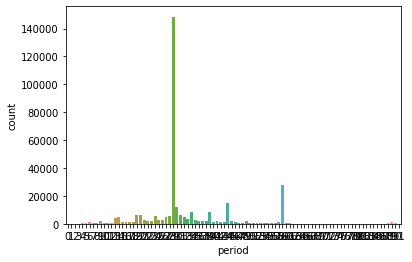

In [12]:
# とりあえず可視化する
sns.countplot(df_ks.period)
plt.show()

1ヵ月となる30日付近にデータが多く、次いで2ヵ月となる60日付近にデータが多い。データが多いので、週で分けることを考える。

In [13]:
df_ks["period_week"] = df_ks["period"] / 7

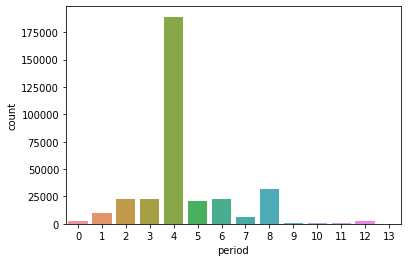

In [14]:
# とりあえず可視化する
sns.countplot((df_ks["period"] / 7).astype('int64'))
plt.show()

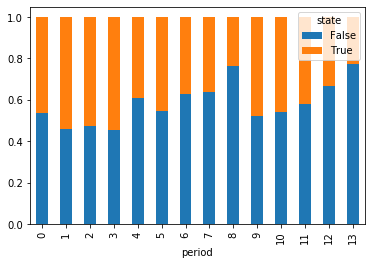

In [15]:
period_state = pd.crosstab((df_ks["period"] / 7).astype('int64'), df_ks["state"], normalize="index")
period_state.plot.bar(stacked=True)
plt.show()

期間と目的変数であるstateの間には相関が見られないと考える。しかし、募集金額と募集期間に相関があると考える。

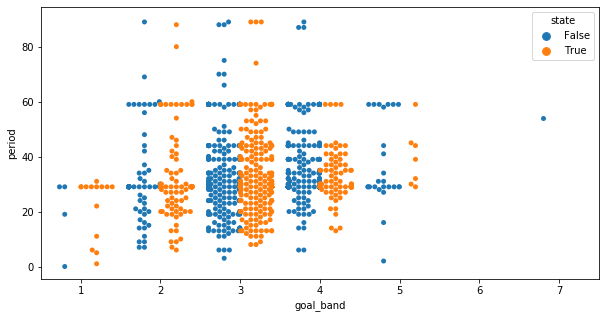

In [16]:
# 目標金額と募集期間ごとにstateをプロット
df_ks["goal_band"] = df_ML["goal_band"]
plt.figure(figsize=(10,5))
sns.swarmplot("goal_band", "period", data=df_ks[df_ks.index%250 == 0], hue="state",dodge=1)
plt.show() # 250個につき1つ

goal_bandとperiodとで全て予想できるほどの強い相関はないものの、例えばgoal_bandが4および5となるデータに着目すると、募集期間periodが極端に短いものおよび極端に長いものは失敗する傾向が見られる。そのため、変数間の関係性も考慮できるモデルであれば有用であると考えられる。（？）

In [17]:
# 追加
df_ML["period"] = df_ks["period"]

### 名前(name)
クラウドファンディングする側にとって、タイトルは重要であると考える。"?"や"!"で終われば閲覧者の目を引くと考えられるし、タイトルで詳しく書く方が目を引くとも予想する。

In [18]:
df_ks["name_!"] = df_ks["name"].str[-1] == "!"
df_ks["name_?"] = df_ks["name"].str[-1] == "?"

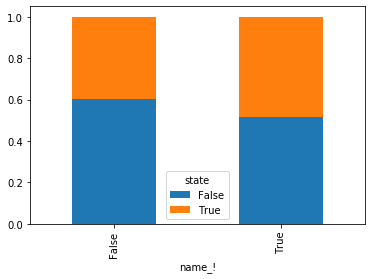

In [19]:
exclamation_state = pd.crosstab(df_ks["name_!"], df_ks["state"], normalize="index")
exclamation_state.plot.bar(stacked=True)
plt.show()

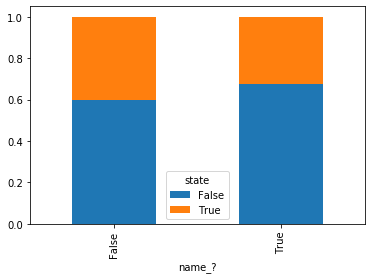

In [20]:
question_state = pd.crosstab(df_ks["name_?"], df_ks["state"], normalize="index")
question_state.plot.bar(stacked=True)
plt.show()

!で終わればクラウドファンディングの成功率が上がり、?の疑問形で終わると成功率が低くなることがわかったため説明変数として有用であると考えられ、説明変数として採用することとする。

In [21]:
df_ML["name_!"] = df_ks["name_!"]
df_ML["name_?"] = df_ks["name_?"]

## 2.2 データの加工

### 標準化
先ほど作成した期間について、標準化を施す。

In [22]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_ML["period"] = stdsc.fit_transform(df_ML[["period"]].values)

In [23]:
# トレーニングデータと、検証用データに分ける。
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df_ML, test_size=0.3, random_state=1234)
# それぞれ説明変数、目的変数に分ける
train_X = df_train[df_ML.columns[1:]]
train_Y = df_train[df_ML.columns[0]]
test_X  = df_test[df_ML.columns[1:]]
test_Y  = df_test[df_ML.columns[0]]
# ロジスティック回帰
clf = SGDClassifier(loss="log", penalty="none", max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-4)
clf.fit(train_X, train_Y)
# 予測
y_pred = clf.predict(test_X)
# 結果を確認する
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy）  = 63.221%
再現率（Recall）    = 84.307%
適合率（Precision） = 64.692%
F1値　（f1 score）  = 73.208%


期間、name_!およびname_?の導入前はそれぞれ  
正答率（Accuracy）  = 65.864%  
再現率（Recall）    = 78.002%  
適合率（Precision） = 68.860%  
であったので、性能としては大差がなかった。しかしながら、利用している予測モデル次第であるはずであり、このまま追加する。
先ほど**データの軽量化**を行ったが、予測精度に影響していないと言えることから**適切な軽量化を行えた**と考える。

### 目標金額について
目標金額の取り扱いについて、bandとしていたが標準化して用いることも検討する。

In [24]:
# df_ML["goal_band"] = pd.cut(df_ks["usd_goal_real"], [0, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e9], labels=range(1,8))

上述の通り、  
正答率（Accuracy）  = 63.221%  
再現率（Recall）    = 84.307%  
適合率（Precision） = 64.692%  
F1値　（f1 score）  = 73.208%  
である。

#### 標準化して用いる場合

In [25]:
df_ML = df_ML.drop(columns=['goal_band'])
stdsc = StandardScaler()
df_ML["goal"] = stdsc.fit_transform(df_ks[["usd_goal_real"]].values)

In [26]:
# トレーニングデータと、検証用データに分ける。
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df_ML, test_size=0.3, random_state=1234)
# それぞれ説明変数、目的変数に分ける
train_X = df_train[df_ML.columns[1:]]
train_Y = df_train[df_ML.columns[0]]
test_X  = df_test[df_ML.columns[1:]]
test_Y  = df_test[df_ML.columns[0]]
# ロジスティック回帰
clf = SGDClassifier(loss="log", penalty="none", max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-4)
clf.fit(train_X, train_Y)
# 予測
y_pred = clf.predict(test_X)
# 結果を確認する
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy）  = 63.110%
再現率（Recall）    = 81.140%
適合率（Precision） = 65.345%
F1値　（f1 score）  = 72.391%


どちらでもほとんど変わらなかったが、バンド化したほうがF1値がわずかに良いのでバンド化して用いることにする。

In [27]:
# 標準化したものを削除、バンド化したものを再び追加
df_ML = df_ML.drop(columns=['goal'])
df_ML["goal_band"] = pd.cut(df_ks["usd_goal_real"], [0, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e9], labels=range(1,8))

# 3 新たなモデルの利用
## 3.1 L2正則化 (Ridge)
係数の値が小さくなるように正則化する。

In [28]:
from sklearn.linear_model import RidgeClassifier
def ridge(DF, ALPHA):
    # トレーニングデータと、検証用データに分ける。
    df_train,df_test = train_test_split(DF, test_size=0.3, random_state=1234)
    # それぞれ説明変数、目的変数に分ける
    train_X = df_train[df_ML.columns[1:]]
    train_Y = df_train[df_ML.columns[0]]
    test_X  = df_test[df_ML.columns[1:]]
    test_Y  = df_test[df_ML.columns[0]]
    # ロジスティック回帰
    clf = RidgeClassifier(alpha=ALPHA, max_iter=1e8)
    clf.fit(train_X, train_Y)
    # 予測
    y_pred = clf.predict(test_X)
    # 結果を確認する
    accuracy = accuracy_score(test_Y, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
    print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
    print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))
    print()

In [29]:
alphas = [1e-1, 1e0, 1e1, 100.0]
for alpha in alphas:
    print('alpha = {:.1e}'.format(alpha))
    ridge(df_ML, alpha)

alpha = 1.0e-01
正答率（Accuracy）  = 63.158%
再現率（Recall）    = 85.317%
適合率（Precision） = 64.416%
F1値　（f1 score）  = 73.408%

alpha = 1.0e+00
正答率（Accuracy）  = 63.159%
再現率（Recall）    = 85.319%
適合率（Precision） = 64.416%
F1値　（f1 score）  = 73.408%

alpha = 1.0e+01
正答率（Accuracy）  = 63.159%
再現率（Recall）    = 85.325%
適合率（Precision） = 64.415%
F1値　（f1 score）  = 73.410%

alpha = 1.0e+02
正答率（Accuracy）  = 63.150%
再現率（Recall）    = 85.347%
適合率（Precision） = 64.404%
F1値　（f1 score）  = 73.411%



再現率が向上し、正答率と適合率が低下した。F1値は向上した。  
αによって結果が全くと言っていいほど変わらないのが気になる。

## 3.1 L1正則化 (Lasso)
係数の値が小さくなるように正則化する。

In [30]:
from sklearn.linear_model import Lasso
def lasso(DF, ALPHA):
    # トレーニングデータと、検証用データに分ける。
    df_train,df_test = train_test_split(DF, test_size=0.3, random_state=1234)
    # それぞれ説明変数、目的変数に分ける
    train_X = df_train[df_ML.columns[1:]]
    train_Y = df_train[df_ML.columns[0]]
    test_X  = df_test[df_ML.columns[1:]]
    test_Y  = df_test[df_ML.columns[0]]
    # ロジスティック回帰
    clf = Lasso(alpha=ALPHA, max_iter=1e8)
    clf.fit(train_X, train_Y)
    # 予測
    y_pred = clf.predict(test_X)
    y_pred =[p >= 0.5 for p in y_pred]
    # 結果を確認する
    accuracy = accuracy_score(test_Y, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
    print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
    print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))
    plt.figure(figsize=(10,5))

alpha = 1.0e-05
正答率（Accuracy）  = 63.154%
再現率（Recall）    = 85.313%
適合率（Precision） = 64.413%
F1値　（f1 score）  = 73.405%


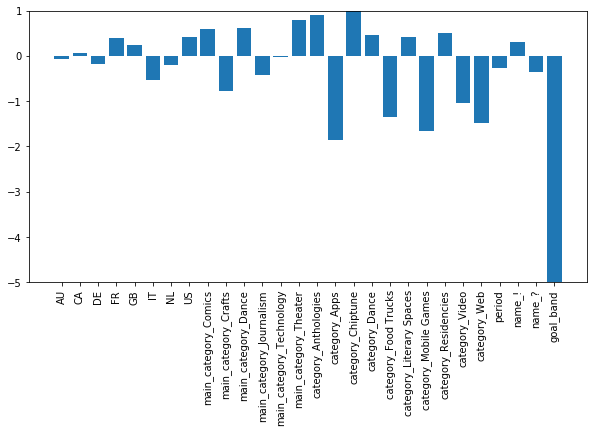


alpha = 1.0e-04
正答率（Accuracy）  = 63.159%
再現率（Recall）    = 85.342%
適合率（Precision） = 64.411%
F1値　（f1 score）  = 73.414%


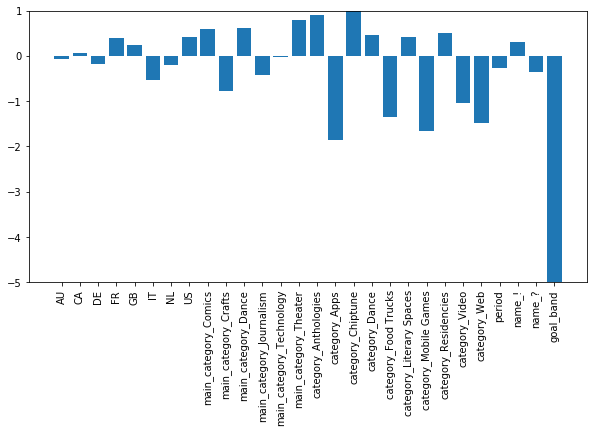


alpha = 1.0e-03
正答率（Accuracy）  = 62.940%
再現率（Recall）    = 85.750%
適合率（Precision） = 64.147%
F1値　（f1 score）  = 73.392%


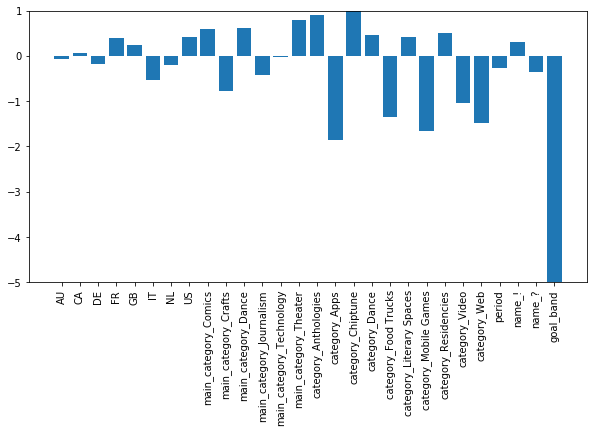


alpha = 1.0e-02
正答率（Accuracy）  = 60.954%
再現率（Recall）    = 88.733%
適合率（Precision） = 62.061%
F1値　（f1 score）  = 73.038%


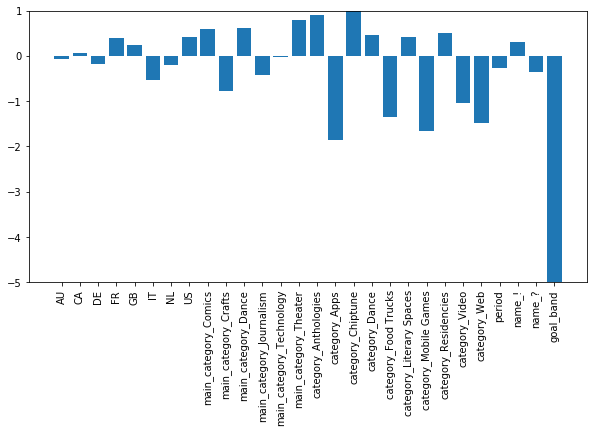

In [31]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2]
for alpha in alphas:
    print('alpha = {:.1e}'.format(alpha))
    lasso(df_ML, alpha)
    plt.bar(range(len(clf.coef_[0])), clf.coef_[0], tick_label=df_ML.columns[1:])
    plt.xticks(rotation=90)
    plt.ylim([-5, 1])
    plt.show()
    print()

やはりαによりほとんど変化しない。goal_bandは非常によく効いていた。(-15程度)

## 3.3 SVMの利用
二値分類問題で利用可能なアルゴリズムであるSVMを利用する。

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
df_train,df_test = train_test_split(df_ML, test_size=0.9999, random_state=1234)

データ数が多いため？計算が終わらなかった。

## 4 まとめ
正答率は低下したものの、データの削減を行いながらDay1と同程度の正答率を維持できたことが収穫であったと考える。  
再現率は比較的簡単に上がり頭打ちになるため、Day1のまとめにも書いた通り失敗を予測するのが難しいと感じる。